# 16S database comparison

Compares multiple databases: Greengenes, SILVA, NCBI RefSeq, and GTDB

In [1]:
import os
import qiime2 as q2
import pandas as pd
from qiime2.plugins import rescript, taxa as q2t
import tempfile
from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
from re import sub
import warnings

import rescript as rpt

%matplotlib inline


# Get NCBI data

In [4]:
dbdir = '../../../ref_dbs/'

In [4]:
# ncbi_seqs_all, ncbi_taxa_all, = rescript.actions.get_ncbi_data('33175[BioProject] OR 33317[BioProject]')
# ncbi_seqs_all.save(dbdir + 'ncbi-refseq/ncbi-refseqs-071420-unfiltered.qza')
# ncbi_taxa_all.save(dbdir + 'ncbi-refseq/ncbi-refseqs-taxa-071420-unfiltered.qza')

In [5]:
ncbi_seqs_all = q2.Artifact.load(dbdir + 'ncbi-refseq/ncbi-refseqs-071420-unfiltered.qza')
ncbi_taxa_all = q2.Artifact.load(dbdir + 'ncbi-refseq/ncbi-refseqs-taxa-071420-unfiltered.qza')

In [4]:
# filter out unusually short seqs
ncbi_seqs, ncbi_discarded, = rescript.actions.filter_seqs_length_by_taxon(
    sequences=ncbi_seqs_all, taxonomy=ncbi_taxa_all,
    labels=['Archaea', 'Bacteria'], min_lens=[900, 1200])

ncbi_taxa = ncbi_taxa_all.view(pd.Series)
ncbi_taxa = ncbi_taxa.loc[ncbi_taxa.view(pd.Series).index]
ncbi_taxa.index.name = 'Feature ID'
ncbi_taxa = q2.Artifact.import_data('FeatureData[Taxonomy]', ncbi_taxa)

# ncbi_seqs.save(dbdir + 'ncbi-refseq/ncbi-refseqs-071420.qza')
# ncbi_taxa.save(dbdir + 'ncbi-refseq/ncbi-refseqs-taxa-071420.qza')

'../../../ref_dbs/ncbi-refseq/ncbi-refseqs-taxa-071420.qza'

In [3]:
ncbi_seqs = q2.Artifact.load(dbdir + 'ncbi-refseq/ncbi-refseqs-071420.qza')
ncbi_taxa = q2.Artifact.load(dbdir + 'ncbi-refseq/ncbi-refseqs-taxa-071420.qza')

In [78]:
junk_seqs = ncbi_discarded.view(pd.Series)
junk_taxa = ncbi_taxa_all.view(pd.Series).loc[junk_seqs.index]
junk_taxa

NR_169410.1    k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Corynebacteriales; f__Nocardiaceae; g__Williamsia; s__aurantiacus                                  
NR_157649.1    k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rickettsiales; f__Anaplasmataceae; g__Ehrlichia; s__muris subsp. eauclairensis                
NR_157641.1    k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Sporolactobacillaceae; g__Sporolactobacillus; s__shoreicorticis                                
NR_156167.1    k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Alteromonadales; f__Idiomarinaceae; g__Aliidiomarina; s__soli                                 
NR_152085.1    k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Vibrionales; f__Vibrionaceae; g__Vibrio; s__cidicii                                           
                                                                    ...                                                                                    

In [79]:
junk_seqs.apply(len).value_counts().sort_index()

302     1
367     1
459     1
460     1
525     1
       ..
1191    1
1192    2
1193    1
1195    1
1196    1
Length: 91, dtype: int64

# Get GTDB data

r95 beta release retrieved July 13, 2020, whilst sitting in the sun, Mendocino, CA

In [7]:
gtdbdir = dbdir + 'gtdb/'
# !mkdir {gtdbdir}

In [ ]:
# !wget -O {gtdbdir + 'bac120_ssu_r95.fasta'} https://data.ace.uq.edu.au/public/gtdb/data/releases/release_beta/95.0/bac120_ssu_r95.tsv
# !wget -O {gtdbdir + 'bac120_taxonomy_r95.tsv'} https://data.ace.uq.edu.au/public/gtdb/data/releases/release_beta/95.0/bac120_taxonomy_r95.tsv
# !wget -O {gtdbdir + 'ar122_ssu_r95.fasta'} https://data.ace.uq.edu.au/public/gtdb/data/releases/release_beta/95.0/ar122_ssu_r95.tsv
# !wget -O {gtdbdir + 'ar122_taxonomy_r95.tsv'} https://data.ace.uq.edu.au/public/gtdb/data/releases/release_beta/95.0/ar122_taxonomy_r95.tsv

In [8]:
gtdb_seqs_fp = gtdbdir + 'gtdb_ssu_r95.fasta'
gtdb_taxa_fp = gtdbdir + 'gtdb_taxonomy_r95.tsv'


In [17]:
# !cat {gtdbdir + 'bac120_ssu_r95.fasta'} {gtdbdir + 'ar122_ssu_r95.fasta'} > {gtdb_seqs_fp}
# !cat {gtdbdir + 'bac120_taxonomy_r95.tsv'} {gtdbdir + 'ar122_taxonomy_r95.tsv'} > {gtdb_taxa_fp}

In [9]:
gtdb_seqs_all = q2.Artifact.import_data('FeatureData[Sequence]', gtdb_seqs_fp)
gtdb_taxa_all = q2.Artifact.import_data('FeatureData[Taxonomy]', gtdb_taxa_fp,
                                        view_type='HeaderlessTSVTaxonomyFormat')

In [8]:
# filter out unusually short seqs
gtdb_seqs, gtdb_discarded, = rescript.actions.filter_seqs_length_by_taxon(
    sequences=gtdb_seqs_all, taxonomy=gtdb_taxa_all,
    labels=['Archaea', 'Bacteria'], min_lens=[900, 1200])

gtdb_taxa = gtdb_taxa_all.view(pd.Series)
gtdb_taxa = gtdb_taxa.loc[gtdb_seqs.view(pd.Series).index]
gtdb_taxa.index.name = 'Feature ID'
gtdb_taxa = q2.Artifact.import_data('FeatureData[Taxonomy]', gtdb_taxa)

# gtdb_seqs.save(gtdbdir + 'gtdb_ssu_r95_filtered.qza')
# gtdb_taxa.save(gtdbdir + 'gtdb_taxonomy_r95_filtered.qza')

'../../../ref_dbs/gtdb/gtdb_taxonomy_r95_filtered.qza'

In [10]:
gtdb_seqs = q2.Artifact.load(gtdbdir + 'gtdb_ssu_r95_filtered.qza')
gtdb_taxa = q2.Artifact.load(gtdbdir + 'gtdb_taxonomy_r95_filtered.qza')

In [80]:
junk_seqs = gtdb_discarded.view(pd.Series)
junk_taxa = gtdb_taxa_all.view(pd.Series).loc[junk_seqs.index]
junk_taxa

G000168735    d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Chromatiales;f__Sedimenticolaceae;g__Endoriftia;s__Endoriftia persephone      
G000183865    d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria;s__Listeria marthii                               
G000192415    d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Propionibacteriales;f__Nocardioidaceae;g__Nocardioides;s__Nocardioides sp000192415
G000210015    d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia_A;s__Blautia_A obeum_B                      
G000210555    d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Coprococcus_A;s__Coprococcus_A catus                
                                                                       ...                                                                          
G013331575    d__Archaea;p__Nanoarchaeota;c__Nanoarchaeia;o__Woesearchaeales;f__UBA525;g__UBA525;s__UBA525

In [83]:
junk_seqs.apply(len).value_counts().sort_index()

200     3
201     4
202     5
203     1
204     3
       ..
1193    2
1194    1
1195    1
1198    1
1199    2
Length: 949, dtype: int64

# Get SILVA data

In [5]:
silvadir = dbdir + 'SILVA_138/'
# !mkdir {silvadir}


In [ ]:
# silva_seqs_fp = silvadir + 'silva-138-99-seqs.qza'
# silva_taxa_fp = silvadir + 'silva-138-99-tax.qza'

# !wget -O {silva_seqs_fp} https://data.qiime2.org/2020.6/common/silva-138-99-seqs.qza
# !wget -O {silva_taxa_fp} https://data.qiime2.org/2020.6/common/silva-138-99-tax.qza

# silva_seqs_all = q2.Artifact.load(silva_seqs_fp)
# silva_taxa_all = q2.Artifact.load(silva_taxa_fp)


In [23]:
# Filter out 18S seqs from SILVA
# include = 'd__Bacteria,d__Archaea'

# silva_taxa = silva_taxa_all.view(pd.Series)
# silva_taxa = silva_taxa[silva_taxa.str.contains(include.replace(',', '|'))]
# silva_taxa = q2.Artifact.import_data('FeatureData[Taxonomy]', silva_taxa)

# silva_seqs, = q2t.actions.filter_seqs(silva_seqs_all, silva_taxa_all, include=include)



In [6]:
silva_seqs_fp = silvadir + 'silva-138-99-16s-seqs.qza'
silva_taxa_fp = silvadir + 'silva-138-99-16s-tax.qza'

# silva_seqs.save(silva_seqs_fp)
# silva_taxa.save(silva_taxa_fp)

silva_seqs = q2.Artifact.load(silva_seqs_fp)
silva_taxa = q2.Artifact.load(silva_taxa_fp)

# Load GG data

In [25]:
ggdir = dbdir + 'gg_13_8_otus/'
gg_seqs, = q2.Artifact.import_data('FeatureData[Sequence]',
                                   ggdir + 'rep_set/99_otus.fasta'),
gg_taxa = q2.Artifact.import_data('FeatureData[Taxonomy]',
                                  ggdir + 'taxonomy/99_otu_taxonomy.txt',
                                  view_type='HeaderlessTSVTaxonomyFormat')

# Compare sequence information

In [13]:
db_labels = ['silva_99', 'greengenes_99', 'GTDB', 'NCBI-RefSeq']

# with junky short seqs
# seqs_eval, = rescript.actions.evaluate_seqs(
#     sequences = [silva_seqs, gg_seqs, gtdb_seqs_all, ncbi_seqs_all],
#     labels = db_labels,
#     palette = 'cividis')
# seqs_eval.save('../data/eval/compare_16S_seqs_eval_unfiltered.qzv')
# with filtered final seqs
seqs_eval, = rescript.actions.evaluate_seqs(
    sequences = [silva_seqs, gg_seqs, gtdb_seqs, ncbi_seqs],
    labels = db_labels,
    palette = 'cividis',
    subsample_kmers = 0.2,
    kmer_lengths = [32, 16, 8])
seqs_eval.save('../data/eval/compare_16S_seqs_eval.qzv')


'../data/eval/compare_16S_seqs_eval.qzv'

# Compare taxonomic information

In [90]:
taxonomies = [silva_taxa, gg_taxa, gtdb_taxa, ncbi_taxa]

tax_eval, = rescript.actions.evaluate_taxonomy(
    taxonomies = taxonomies,
    labels = db_labels)
tax_eval.save('../data/eval/compare_16S_taxonomic_eval.qzv')
tax_eval, = rescript.actions.evaluate_taxonomy(
    taxonomies = taxonomies,
    labels = db_labels,
    rank_handle_regex="^[dkpcofgs]__")
tax_eval.save('../data/eval/compare_16S_taxonomic_eval_dropemptyranks.qzv')

'../data/eval/compare_16S_taxonomic_eval_dropemptyranks.qzv'

# Make a pretty plot

In [91]:
fig_data = dict()
with tempfile.TemporaryDirectory() as temp_dir_name:
    for f in glob('../data/eval/compare_16S_taxonomic_*.qzv'):
        name = f.split('/')[-1].split('.qzv')[0]
        f = q2.Visualization.load(f)
        f.export_data(temp_dir_name)
        fig_data[name] = q2.Metadata.load(temp_dir_name + '/data.tsv').to_dataframe()


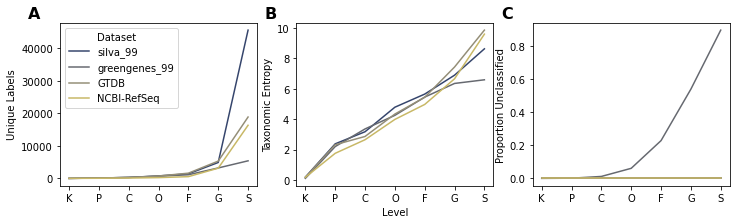

In [104]:
plot_keys = ['compare_16S_taxonomic_eval',
             'compare_16S_taxonomic_eval',
             'compare_16S_taxonomic_eval_dropemptyranks']
signals = ['Unique Labels',
           'Taxonomic Entropy',
           'Proportion of Features Unclassified at Depth']
labels = list('ABCDEF')

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=False)
axes = axes.flatten()
for ax, key, signal, label in zip(axes, plot_keys, signals, labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')
    dat = fig_data[key].copy()
    #dat.loc[:, 'Dataset'] = dat.loc[:, 'Dataset'].replace(relabels)
    dat = dat[dat['Dataset'] != 'drop']
    dat['Level'] = dat['Level'].replace({
        1: 'K', 2: 'P', 3: 'C', 4: 'O',
        5: 'F', 6: 'G', 7: 'S'})
    if ax == axes[0]:
        legend = 'brief'
    else:
        legend = False
    g = sns.lineplot(x='Level', y=signal, hue='Dataset', data=dat, ax=ax,
                     legend=legend, palette='cividis', sort=False,
                     hue_order=db_labels)
    if ax == axes[2]:
        ax.set_ylabel('Proportion Unclassified')
    if ax != axes[1]:
        ax.set_xlabel('')
#fig.savefig('../data/plots/compare_16S_taxonomy_evaluation.pdf', bbox_inches='tight')


# A deeper look at SILVA taxonomy

In [215]:
some_silva = silva_taxa.view(pd.Series)


### too many species ("organism names") don't match their genera!

In [216]:
# number of taxa with species-genus match
def genus_species_match(taxon_string):
    genus, species = taxon_string.split('; g__')[-1].split('; s__')
    genus = genus.strip(' []')
    species_parts = [t.strip(' []') for t in species.split('_')]
    return genus in species_parts or species_parts[0] in genus



In [217]:
# don't count unidentified, chloroplast, or mitochondria when looking for mismatched species
# drop the leading character to cheat on case matching
exclude = ['s__unidentified', 'hloroplast', 'itochondria', 's__uncultured', 's__uncultivated',
           'etagenome', 'andidatus', 'ryza_sativa', '_bacterium', '_proteobacterium', 'manure',
           'arctic', 'marine', 'water', 'gut', 'symbiont', 'oral', 'lake', 'sea',
           'microbial_mat', 'glacial', 'drainage', 'thermal_vent', 'nrichment', 
           'synthetic', 'candidate', 'clone', 'mineralizing', 'swine', 'isolate',
           'aerobic', 'hot_spring', 'halophilic', 'gas_vacuolate']

clean_silva = some_silva.copy()
for e in exclude:
    start = len(clean_silva)
    clean_silva = clean_silva[-clean_silva.str.contains(e)]
    print(e + ': ' + str(start - len(clean_silva)))
total_silva = len(some_silva)
print('Total SILVA: ' + str(total_silva))
print('Total Unclean: ' + str(total_silva - len(clean_silva)))

good, bad = clean_silva.apply(genus_species_match).value_counts().values
print('Cleaned species match: ' + str(good))
print('Cleaned species do not match: ' + str(bad))
print('Percent of SILVA with good species IDs: ' + str(good / total_silva * 100))



s__unidentified: 1160
hloroplast: 4137
itochondria: 490
s__uncultured: 258975
s__uncultivated: 6
etagenome: 7156
andidatus: 2184
ryza_sativa: 4
_bacterium: 5865
_proteobacterium: 597
manure: 8
arctic: 220
marine: 72
water: 74
gut: 128
symbiont: 312
oral: 1256
lake: 29
sea: 226
microbial_mat: 32
glacial: 26
drainage: 17
thermal_vent: 58
nrichment: 70
synthetic: 14
candidate: 72
clone: 9
mineralizing: 9
swine: 21
isolate: 3
aerobic: 46
hot_spring: 12
halophilic: 5
gas_vacuolate: 1
Total SILVA: 389016
Total Unclean: 283294
Cleaned species match: 95966
Cleaned species do not match: 9756
Percent of SILVA with good species IDs: 24.66890821971333


In [105]:
clean_silva[-clean_silva.apply(genus_species_match)].apply(lambda x: x.split('; g__')[-1])[:50]


Feature ID
CP022099.688126.689680                      Vibrio; s__Listonella_anguillarum
CP021040.609953.611404         Rhodobacteraceae; s__Phaeobacter_gallaeciensis
CP014154.4379805.4381358          Enterobacter; s__Klebsiella_quasipneumoniae
CP011246.2508993.2510465    Allorhizobium-Neorhizobium-Pararhizobium-Rhizo...
CP013829.118274.119809               Mycoplasma; s__Mycoplasmoides_pneumoniae
CP014259.1494007.1495498    Allorhizobium-Neorhizobium-Pararhizobium-Rhizo...
CP014029.2901541.2903090                Enterobacter; s__Klebsiella_aerogenes
CP020534.551348.552902                      Vibrio; s__Listonella_anguillarum
CP023310.293648.295202                      Vibrio; s__Listonella_anguillarum
CP010038.2988408.2989837                    Vibrio; s__Listonella_anguillarum
CP017327.118270.119805               Mycoplasma; s__Mycoplasmoides_pneumoniae
AP018307.4725006.4726492                        Tolypothrix; s__Aulosira_laxa
CP031837.273576.275080      Erysipelotrichaceae_UCG-0

# Compare Classification Accuracy

In [304]:
# N jobs to use
n_jobs = 2

# data to classify
data = [('gtdb', gtdb_seqs, gtdb_taxa),
        ('ncbi', ncbi_seqs, ncbi_taxa)]


In [315]:
# Note: NCBI and GTDB do not do well with CV due to lack of replication
# GG and SILVA do better because of high redundancy 
# hence this is run for completeness but won't be used in final results
# Cross-validation
for n, s, t in data:
    print(n)
    exp_taxa_fp = '../data/expected/{0}_expected_taxonomy.qza'.format(n)
    if not os.path.exists(exp_taxa_fp):
        try:
            exp, obs, _ = rescript.actions.evaluate_cross_validate(s, t, n_jobs=n_jobs)
        # NOTE: species class sizes are too small in GTDB (N=1), so we will trim to genus level
        except ValueError:
            print('trimming taxa')
            t = q2.Artifact.import_data(
                'FeatureData[Taxonomy]',
                t.view(pd.Series).apply(
                    lambda x: ';'.join(rpt._utilities._taxon_to_list(x, '')[:6])))
            exp, obs, _ = rescript.actions.evaluate_cross_validate(s, t, n_jobs=n_jobs)
        exp.save(exp_taxa_fp)
        obs.save('../data/observed/{0}_observed_taxonomy.qza'.format(n))

gtdb
Validation: 1.23s
trimming taxa
Validation: 1.23s
Fold 0 split: 2.44s
Fold 0 fit: 86.74s
Fold 0 classify: 146.87s
Fold 1 split: 2.30s
Fold 1 fit: 82.84s
Fold 1 classify: 129.44s
Fold 2 split: 2.27s
Fold 2 fit: 82.14s
Fold 2 classify: 136.73s
Evaluation: 1.04s
Total Runtime: 674.04s
ncbi
Validation: 1.44s
Fold 0 split: 3.55s
Fold 0 fit: 251.69s
Fold 0 classify: 512.17s
Fold 1 split: 3.05s
Fold 1 fit: 254.40s
Fold 1 classify: 517.80s
Fold 2 split: 2.72s
Fold 2 fit: 244.89s
Fold 2 classify: 493.30s
Evaluation: 1.71s
Total Runtime: 2286.71s


In [20]:
# "Perfect" classifier, no cross-validation
for n, s, t in data:
    print(n)
    obs_taxa_fp = '../data/observed/{0}_observed_taxonomy_noCV.qza'.format(n)
    exp_taxa_fp = '../data/expected/{0}_expected_taxonomy_noCV.qza'.format(n)
    if not os.path.exists(exp_taxa_fp):
        _, _, obs, = rescript.actions.evaluate_fit_classifier(s, t, n_jobs=n_jobs)
        obs.save(obs_taxa_fp)
        t.save(exp_taxa_fp)


gtdb
Validation: 1.60s
Training: 547.34s
Classification: 2177.43s


/Users/nbokulich/Desktop/projects/RESCRIPt/rescript/evaluate.py:76: UserWarning: The lists of input taxonomies and labels are different lengths. Additional taxonomies will be labeled numerically by their order in the inputs. Note that if these numbers match existing labels, those data will be grouped in the visualization.
  warnings.warn(msg, UserWarning)


Evaluation: 1.13s
Total Runtime: 2727.50s
ncbi
Validation: 1.48s
Training: 481.03s
Classification: 2135.28s


/Users/nbokulich/Desktop/projects/RESCRIPt/rescript/evaluate.py:76: UserWarning: The lists of input taxonomies and labels are different lengths. Additional taxonomies will be labeled numerically by their order in the inputs. Note that if these numbers match existing labels, those data will be grouped in the visualization.
  warnings.warn(msg, UserWarning)


Evaluation: 1.28s
Total Runtime: 2619.07s


In [11]:
labels = ['GTDB', 'GTDB_noCV', 'NCBI', 'NCBI_noCV', 'GG', 'GG_noCV', 'SILVA', 'SILVA_noCV']
expected = [q2.Artifact.load('../data/expected/gtdb_expected_taxonomy.qza'),
            q2.Artifact.load('../data/expected/gtdb_expected_taxonomy_noCV.qza'),
            q2.Artifact.load('../data/expected/ncbi_expected_taxonomy.qza'),
            q2.Artifact.load('../data/expected/ncbi_expected_taxonomy_noCV.qza'),
            q2.Artifact.load('../data/expected/gg_99_expected_taxonomy.qza'),
            q2.Artifact.load('../data/expected/gg_99_expected_taxonomy_noCV.qza'),
            q2.Artifact.load('../data/expected/silva-nr99-default-noeuks-derep-taxa-ecv-exptax.qza'),
            q2.Artifact.load(silvadir + 'silva-nr99-default-noeuks-derep-taxa.qza'),
           ]
observed = [q2.Artifact.load('../data/observed/gtdb_observed_taxonomy.qza'),
            q2.Artifact.load('../data/observed/gtdb_observed_taxonomy_noCV.qza'),
            q2.Artifact.load('../data/observed/ncbi_observed_taxonomy.qza'),
            q2.Artifact.load('../data/observed/ncbi_observed_taxonomy_noCV.qza'),
            q2.Artifact.load('../data/observed/gg_99_observed_taxonomy.qza'),
            q2.Artifact.load('../data/observed/gg_99_observed_taxonomy_noCV.qza'),
            q2.Artifact.load('../data/observed/silva-nr99-default-noeuks-derep-taxa-ecv-obstax.qza'),
            q2.Artifact.load('../data/observed/silva-nr99-default-noeuks-derep-taxa-efc-obstax.qza')]
ev, = rescript.actions.evaluate_classifications(expected, observed, labels)
ev.save('../data/eval/compare_16S_classification_eval.qzv')

'../data/eval/compare_16S_classification_eval.qzv'

# Taxonomic overlap

In [199]:
def _get_per_level_labels(series, rank_handle="^[dkpcofgs]__"):
    series = series.apply(
        # strip off tags on the end of taxa labels, e.g., subgroup IDs used by GTDB
        lambda x: [sub("_.??$", '', i) for i in 
                   rpt._utilities._taxon_to_list(x, rank_handle=rank_handle)])
    return [set(v) for v in itertools.zip_longest(*series.values)]


In [219]:
gt = _get_per_level_labels(gtdb_taxa.view(pd.Series))
nt = _get_per_level_labels(ncbi_taxa.view(pd.Series))
st = _get_per_level_labels(silva_taxa.view(pd.Series))
gg = _get_per_level_labels(gg_taxa.view(pd.Series))


In [290]:
# strip genus names from SILVA and GTDB species labels to match other taxonomies
st[-1] = {i.split('_')[1].strip('[]') if '_' in i and i.split('_')[0] in st[-2] else i for i in st[-1]}
gt[-1] = {i if sub("_.??$", '', i.split(' ')[0]) not in gt[-2] else i.split(' ')[1].strip('[]') for i in gt[-1]}

In [291]:
taxonomies = {'GTDB': gt, 'NCBI': nt, 'SILVA': st, 'GG': gg}

n_taxonomies = len(taxonomies.keys())

# iterate over all combinations of taxonomies
# this starts at 1 to count unique values in each taxonomy
all_combinations = [i for sublist in [itertools.combinations(taxonomies.keys(), r)
                   for r in range(1, n_taxonomies + 1)] for i in sublist]
overlap = dict()
for level in range(0, 7):
    overlap[level] = dict()
    for combo in all_combinations:
        combo = list(combo)
        name = '-'.join([i for i in combo])
        shared = taxonomies[combo.pop()][level]
        while combo:
            shared = shared.intersection(taxonomies[combo.pop()][level]) - {None, ''}
        overlap[level][name] = len(shared)
    

In [293]:
overlap_data = pd.DataFrame(overlap)
overlap_data.columns = ['D', 'P', 'C', 'O', 'F', 'G', 'S']
overlap_data.to_csv('../data/plots/compare_16S_shared_labels.tsv', sep='\t')
overlap_data

,D,P,C,O,F,G,S
GTDB,2,106,286,719,1573,4775,14335
NCBI,2,41,99,234,537,3132,9962
SILVA,2,105,279,728,1303,4478,16513
GG,2,90,248,405,514,2063,2514
GTDB-NCBI,2,6,59,148,342,2219,4887
GTDB-SILVA,2,59,144,276,516,2135,5107
GTDB-GG,2,10,47,115,250,1368,1649
NCBI-SILVA,2,8,63,176,400,2587,7092
NCBI-GG,2,29,57,124,279,1524,1886
SILVA-GG,2,21,61,144,282,1495,1980


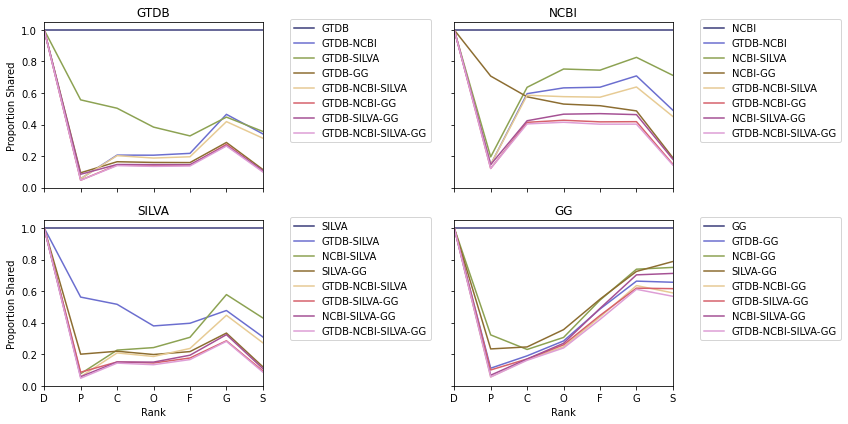

In [296]:
# ignore matplotlib deprecation warnings, which relate to pandas plot
warnings.simplefilter("ignore")

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)
axes = axes.flatten()
for ax, key in zip(axes, taxonomies.keys()):
    plot_dat = overlap_data.copy()
    plot_dat = plot_dat.drop([i for i in overlap_data.index if key not in i])
    plot_dat = plot_dat / plot_dat.max()
    if ax == axes[-1]:
        legend = True
    else:
        legend = False
    plot_dat.T.plot(kind='line', colormap='tab20b', legend=legend, ax=ax)
    ax.set_title(key)
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    ax.set_ylabel('Proportion Shared')
    ax.set_xlabel('Rank')
    
plt.tight_layout()
fig.savefig('../data/plots/compare_16S_shared_labels.pdf', bbox_inches='tight')


# Make a Pretty Figure

In [12]:
fig_data = dict()
with tempfile.TemporaryDirectory() as temp_dir_name:
    files = glob('../data/eval/compare_16S_taxonomic_*.qzv') 
    files += ['../data/eval/compare_16S_classification_eval.qzv']
    for f in files:
        name = f.split('/')[-1].split('.qzv')[0]
        f = q2.Visualization.load(f)
        f.export_data(temp_dir_name)
        fig_data[name] = q2.Metadata.load(temp_dir_name + '/data.tsv').to_dataframe()


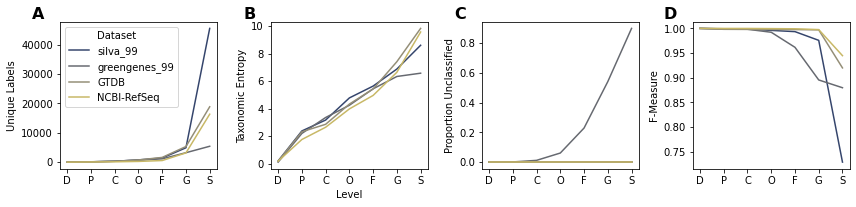

In [14]:
db_labels = ['silva_99', 'greengenes_99', 'GTDB', 'NCBI-RefSeq']
plot_keys = ['compare_16S_taxonomic_eval',
             'compare_16S_taxonomic_eval',
             'compare_16S_taxonomic_eval_dropemptyranks',
             'compare_16S_classification_eval']
signals = ['Unique Labels',
           'Taxonomic Entropy',
           'Proportion of Features Unclassified at Depth',
           'F-Measure']
labels = list('ABCDEF')

fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharex=False)
axes = axes.flatten()
for ax, key, signal, label in zip(axes, plot_keys, signals, labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')
    dat = fig_data[key].copy()
    #dat.loc[:, 'Dataset'] = dat.loc[:, 'Dataset'].replace(relabels)
    dat = dat[dat['Dataset'] != 'drop']
    dat['Level'] = dat['Level'].replace({
        1: 'D', 2: 'P', 3: 'C', 4: 'O',
        5: 'F', 6: 'G', 7: 'S'})
    if ax == axes[0]:
        legend = 'brief'
    else:
        legend = False
    if ax == axes[-1]:
        dat = dat[dat['Dataset'].isin([
            'GG_noCV', 'SILVA_noCV', 'GTDB_noCV', 'NCBI_noCV'])]
        dat['Dataset'] = dat['Dataset'].replace({
            'GG_noCV': 'greengenes_99', 'SILVA_noCV': 'silva_99',
            'GTDB_noCV': 'GTDB', 'NCBI_noCV': 'NCBI-RefSeq'})
    g = sns.lineplot(x='Level', y=signal, hue='Dataset', data=dat, ax=ax,
                     legend=legend, palette='cividis', sort=False,
                     hue_order=db_labels)
    if ax == axes[2]:
        ax.set_ylabel('Proportion Unclassified')
    if ax != axes[1]:
        ax.set_xlabel('')
fig.tight_layout()
fig.savefig('../data/plots/compare_16S_taxonomy_evaluation.pdf', bbox_inches='tight')
